## <div align="center">SVM</div>

In [1]:
import os
import numpy as np
import pandas as pd
from tables import *
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

### INTRODUCTION: in this Jupyter Notebook I will apply SVM, find best hyperparameters and use ROC/AUC.

### Part 1. Random model
### Part 2. Tuned model
### Part 3. Conclusion

## <div align="center">LOAD DATA</div>

In [2]:
features_array = np.load('features_array_2.0.npy')
label_array = np.load('label_array_2.0.npy')

In [3]:
print(features_array.shape)
print(label_array.shape)

(1080, 60)
(1080,)


# <div align="center">PART 1. Random model</div>

## <div align="center">SVM with randomly picked hyperparameters.</div>

Standard logic for the SVM. I begin with simple setup to see what would be the output of an unconfigured system.


In [4]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

X = features_array
y = label_array

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


# StandardScaler is a method of feature scaling that is used to standardize the range of input features.
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Instantiate the Support Vector Classifier (SVC)
svc = SVC(C=5.0, random_state=10, kernel='poly', probability=True)
 
# Fit the model
svc.fit(X_train_std, y_train) 

# Make the predictions
y_predict = svc.predict(X_test_std) 

## Accuracy and Classification Report

In [5]:
# Create a dict which will be used for labeling Classification Report and Confusion Matrix
label_mapping = {0: 'breathing', 1: 'coughing', 2: 'footsteps', 3: 'laughing', 4: 'sneezing', 5: 'snoring', 6: 'toilet_flush', 7: 'vacuum_cleaner', 8: 'washing_machine'}
categories = ['breathing', 'coughing', 'footsteps', 'laughing', 'sneezing', 'snoring', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']

# Calculate Accuracy
acc_score = accuracy_score(y_test, y_predict)
# Calculate classififcation report
cr = classification_report(y_test, y_predict, target_names=categories)

print("Test Accuracy: ", acc_score)
print("Test Classification Report:")
print(cr)

Test Accuracy:  0.25462962962962965
Test Classification Report:
                 precision    recall  f1-score   support

      breathing       0.21      0.21      0.21        24
       coughing       0.33      0.29      0.31        24
      footsteps       0.30      0.12      0.18        24
       laughing       0.39      0.38      0.38        24
       sneezing       0.36      0.33      0.35        24
        snoring       0.67      0.33      0.44        24
   toilet_flush       0.18      0.33      0.24        24
 vacuum_cleaner       0.11      0.25      0.15        24
washing_machine       0.17      0.04      0.07        24

       accuracy                           0.25       216
      macro avg       0.30      0.25      0.26       216
   weighted avg       0.30      0.25      0.26       216



### Reflection on the Classification Report:
- The **accuracy** is 25% which is low model needs improvments.
- The **precision** is also low for most of the classes. The top one is "snoring" where only 67% were actually "snoring" instances out of all predicted instances.
- The **recall** is also low. "laughing" is 38%, which means that of all the actual "laughing" instances, the model only correctly predicted 38% of them.
- Based on **f1-score**, which provides a balance between precision and recall, I can conclusde that dataset is imbalanced. 



## Confusion Matrix

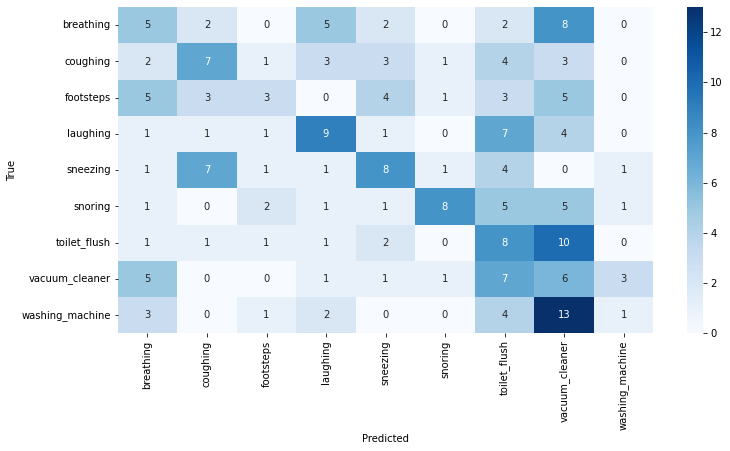

In [6]:
cm = confusion_matrix(y_test, y_predict)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values(), label='Train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Reflection on the Confusion Matrix:
- Ideally I want to see the diagonal cells to have higher values and the off-diagonal cells have lower values. However, in this case I can see that the model is having difficulty distinguishing between some of the classes.
- Confusion Matrix show that "snoring", "sneezing" and "laughing" classied much better than other classes.The worst performance show "washing_machine" and "footsteps".
- I might need to investigate these classes further and consider whether the features I am  using are sufficient to distinguish them.

## Cross Validation

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc, X, y, cv=5) # perform 5-fold cross-validation
print('Cross-validation scores:', scores)


Cross-validation scores: [0.15277778 0.22685185 0.24537037 0.27314815 0.25      ]


### Reflection on Cross Validation:

- The range from 0.15 to 0.27 indicates that the model varies between different splits of the data and thus, different features engineering techniques should be applied.

# <div align="center">ROC & AUC</div>

## Calculate AUC and plot ROC curves for each class

There are lots of information on the internet about ROC curve. The code is a combination of solution found on the internet. Plot as sublots was the most challeging.
- https://stackoverflow.com/questions/45641409/computing-scikit-learn-multiclass-roc-curve-with-cross-validation-cv
- https://pub.towardsai.net/roc-and-auc-for-model-evaluation-2b4997ca6469
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

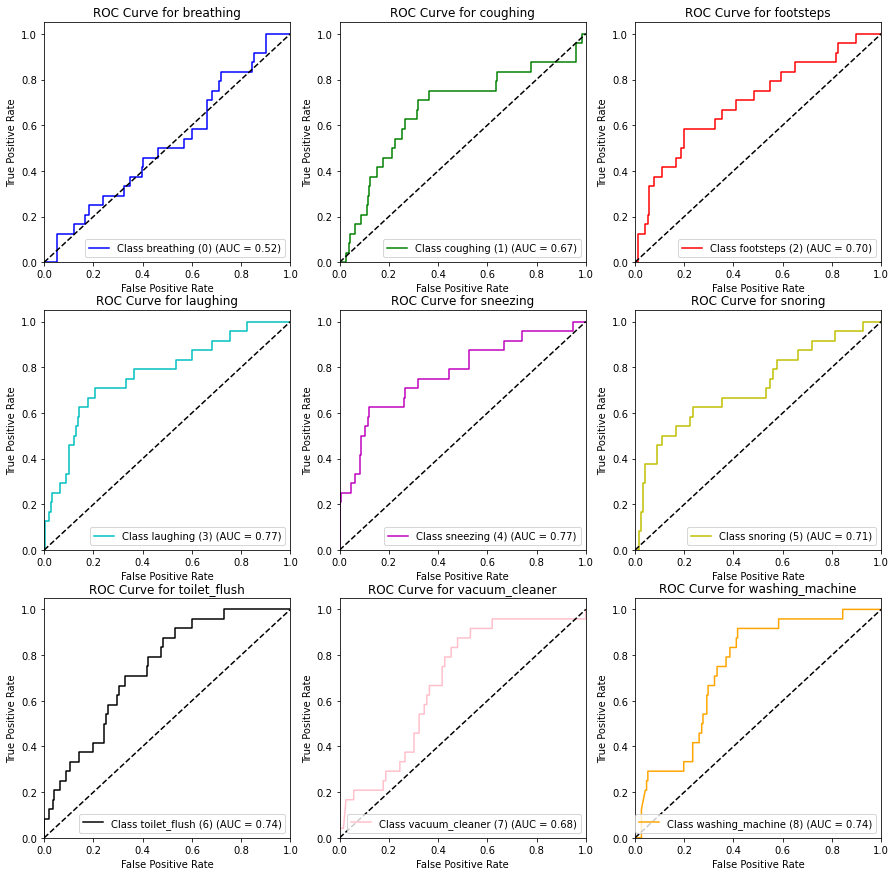

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict the probabilities
y_predict_proba = svc.predict_proba(X_test_std)

# Calculation of ROC AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_train))
categories = ['breathing', 'coughing', 'footsteps', 'laughing', 'sneezing', 'snoring', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange']

# Set up subplots
# fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig, axs = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1, 1]})

# Plot the ROC curve for each class
for i in range(n_classes):
    row = i // 3
    col = i % 3
    y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    y_bin = y_bin[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_bin, y_predict_proba[:, i])
    roc_auc[i] = roc_auc_score(y_bin, y_predict_proba[:, i])
    axs[row, col].plot(fpr[i], tpr[i], colors[i], label='Class {0} ({1}) (AUC = {2:0.2f})'.format(categories[i], i, roc_auc[i]))
    axs[row, col].plot([0, 1], [0, 1], 'k--')
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    axs[row, col].set_xlabel('False Positive Rate')
    axs[row, col].set_ylabel('True Positive Rate')
    axs[row, col].set_title('ROC Curve for {0}'.format(categories[i]))
    axs[row, col].legend(loc="lower right")

plt.show()


In [10]:
# Print out classes and AUC scores 
for i in range(n_classes):
    print('Class {}: {} (AUC = {:.2f})'.format(i, categories[i], roc_auc[i]))


Class 0: breathing (AUC = 0.52)
Class 1: coughing (AUC = 0.67)
Class 2: footsteps (AUC = 0.70)
Class 3: laughing (AUC = 0.77)
Class 4: sneezing (AUC = 0.77)
Class 5: snoring (AUC = 0.71)
Class 6: toilet_flush (AUC = 0.74)
Class 7: vacuum_cleaner (AUC = 0.68)
Class 8: washing_machine (AUC = 0.74)


## Find average AUC and plot ROC

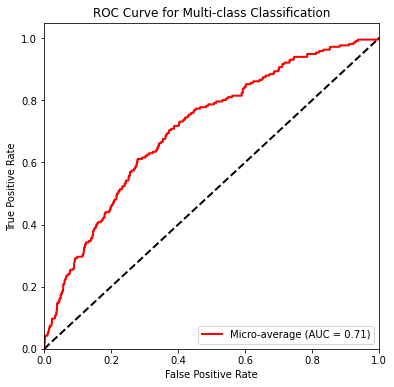

In [11]:
# Predict the probabilities 
y_predict_proba = svc.predict_proba(X_test_std)

# Calculate the micro-averaged ROC AUC score
y_bin_all = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
fpr, tpr, _ = roc_curve(y_bin_all.ravel(), y_predict_proba.ravel())

roc_auc = roc_auc_score(y_bin_all, y_predict_proba, average="micro")


# Plot the micro-averaged ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Micro-average (AUC = {0:0.2f})'.format(roc_auc), linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


### Reflection on ROC/AUC:
AUC values for each class suggest how well the model can distinguish between positive and negative samples. A higher AUC value indicates better separation between the positive and negative samples. Based on the ROC curves ploted above I can assume that for some classes ***(laughing and sneezing with AUC of 0.77)*** the model can perform well, for other classes poorly ***(breathing with an AUC of 0.52)***.

# <div align="center">PART 2. Tuned model</div>

### <div align="center">Tweak Hyperparameters</div>

In the code below, I will split data into 60%, 20%, 20%. 
I will use GridSearchCV, that will help me to find the best hyperparameters among those that I give it to it.
I will also do cross validation -  5-fold cross-validation.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

X = features_array
y = label_array

# Split the data into 60% training, 20% validation, 20% test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=0, stratify=y_val_test)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# Hyperparameters that I will give to GridSearchCV
hyperparameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}

# Create SVM for GridSearchCV
svm_estimator = SVC(probability=True)

# Use GridSearchCV. The goal is to gind best hyperparameters. Plus do 5-fold cross-validation
grid_search = GridSearchCV(svm_estimator, hyperparameters, cv=5)
grid_search.fit(X_val_std, y_val)

# Hyperparameters and validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Validation accuracy:", grid_search.best_score_)

# Train the final model using the best hyperparameters found by GridSearchCV
final_svc = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], gamma=grid_search.best_params_['gamma'], probability=True)
final_svc.fit(X_train_std, y_train)


# Final model evaluation
test_score = final_svc.score(X_test_std, y_test)

# Test accuracy
print("Test accuracy:", test_score)

# Labels for test data
y_pred = final_svc.predict(X_test_std)

# Classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("Classification report:\n", report)

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Validation accuracy: 0.22684989429175478
Test accuracy: 0.26851851851851855
Classification report:
                  precision    recall  f1-score   support

      breathing       0.16      0.21      0.18        24
       coughing       0.46      0.46      0.46        24
      footsteps       0.32      0.29      0.30        24
       laughing       0.62      0.42      0.50        24
       sneezing       0.35      0.29      0.32        24
        snoring       0.19      0.12      0.15        24
   toilet_flush       0.25      0.21      0.23        24
 vacuum_cleaner       0.16      0.38      0.22        24
washing_machine       0.12      0.04      0.06        24

       accuracy                           0.27       216
      macro avg       0.29      0.27      0.27       216
   weighted avg       0.29      0.27      0.27       216



### Reflection on the Classification Report:
- Test **accuracy** is 27% model classify only 1/4 of test set. Model will perform poor for unseen data.
- The **precision** is also low for most of the classes. The top one is "laughing" where only 62% were actually "laughing" instances out of all predicted instances.
- The **recall** is also low. "coughing" is 46%, which means that of all the actual "coughing" instances, the model only correctly predicted 46% of them.
- Based on **f1-score**, which provides a balance between precision and recall, I can conclusde that dataset is imbalanced. 




## Confusion Matrix

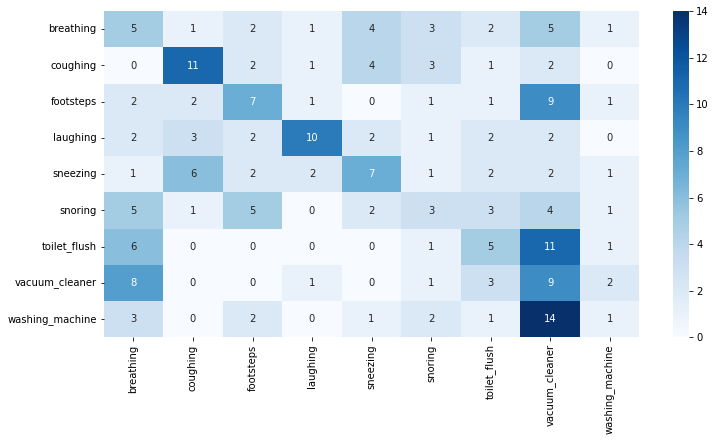

In [13]:
test_cm = confusion_matrix(y_test, y_pred)
# print("")
# print("Confusion matrix:\n", test_cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values(), label='Train')
plt.show()

### Reflection on the Confusion Matrix:
- Ideally I want to see the diagonal cells to have higher values and the off-diagonal cells have lower values.
- 'coughing', 'laughing', 'sneezing' and 'footsteps' have relatively higher true positives.
- 'breathing', 'snoring', 'vacuum_cleaner' and 'washing_machine' have low number of true positives (diagonal elements).
- The model is struggling to distinguish between several classes, which is reflected in the low overall accuracy.


1. Breathing - the model has poor performance.
2. Coughing  - the model has a ***decent*** performance.
3. Footsteps - the model has poor performance.
4. Laughing - the model has a ***decent*** performance.
5. Sneezing - the model has poor performance.
6. Snoring  - the model has poor performance.
7. Toilet flush - the model has poor performance.
8. Vacuum cleaner - the model has poor performance.
9. Washing machine - the model has poor performance. 

## Calculate AUC and plot ROC curves for each class

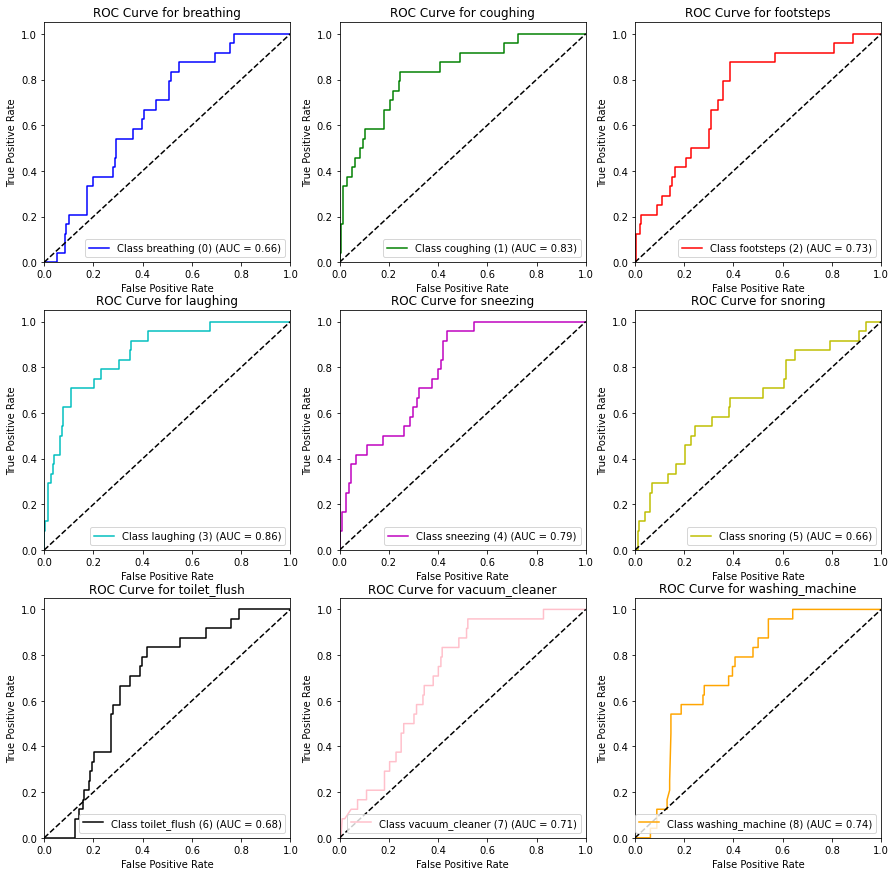

In [15]:
# Predict the probabilities
y_predict_proba = final_svc.predict_proba(X_test_std)

# Calculation the ROC AUC score 
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_train))
categories = ['breathing', 'coughing', 'footsteps', 'laughing', 'sneezing', 'snoring', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange']

# Set up subplots
# fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig, axs = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1, 1]})

# Plot the ROC curve 
for i in range(n_classes):
    row = i // 3
    col = i % 3
    y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    y_bin = y_bin[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_bin, y_predict_proba[:, i])
    roc_auc[i] = roc_auc_score(y_bin, y_predict_proba[:, i])
    axs[row, col].plot(fpr[i], tpr[i], colors[i], label='Class {0} ({1}) (AUC = {2:0.2f})'.format(categories[i], i, roc_auc[i]))
    axs[row, col].plot([0, 1], [0, 1], 'k--')
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    axs[row, col].set_xlabel('False Positive Rate')
    axs[row, col].set_ylabel('True Positive Rate')
    axs[row, col].set_title('ROC Curve for {0}'.format(categories[i]))
    axs[row, col].legend(loc="lower right")

plt.show()

In [16]:
# Print  classes and AUC scores
for i in range(n_classes):
    print('Class {}: {} (AUC = {:.2f})'.format(i, categories[i], roc_auc[i]))



Class 0: breathing (AUC = 0.66)
Class 1: coughing (AUC = 0.83)
Class 2: footsteps (AUC = 0.73)
Class 3: laughing (AUC = 0.86)
Class 4: sneezing (AUC = 0.79)
Class 5: snoring (AUC = 0.66)
Class 6: toilet_flush (AUC = 0.68)
Class 7: vacuum_cleaner (AUC = 0.71)
Class 8: washing_machine (AUC = 0.74)


## Find average AUC and plot ROC

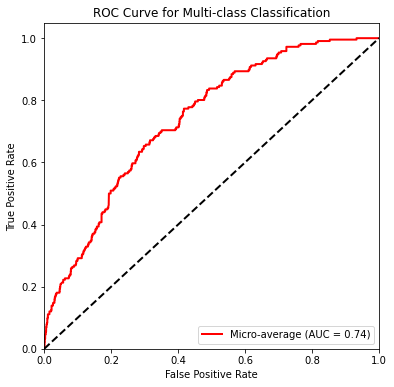

In [17]:
# Predict the probabilities for each class
y_predict_proba = final_svc.predict_proba(X_test_std)

# Calculate the micro-averaged One-vs-Rest ROC AUC score
y_bin_all = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
fpr, tpr, _ = roc_curve(y_bin_all.ravel(), y_predict_proba.ravel())

roc_auc = roc_auc_score(y_bin_all, y_predict_proba, average="micro")

# Plot the micro-averaged ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Micro-average (AUC = {0:0.2f})'.format(roc_auc), linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()



### Reflection on ROC/AUC:
AUC values for each class suggest how well the model can distinguish between positive and negative samples. A higher AUC value indicates better separation between the positive and negative samples. Based on the ROC curves ploted above I can assume that for some classes ***("laughing" and "coughing", with AUC values of 0.86 and 0.83)*** the model can perform well, for other classes poorly ***("snoring" and "breathing", with AUC values of 0.66 and 0.66)***.

### <div align="center">Part 3. Conclusion</div>

### Reflection on ROC/ AUC and comparison of Confusion Matrix/ Classification Report:
- AUC measures how well the model is able to distinguish between different classes.
- CM/CR measure the performance of the model in terms of correctly classifying samples.

AUC looks better than CM/CR, but still have poor performance.
The model is not able to accurately classify the samples.
**Reasons:**

1. Underfitting or overfitting the data
2. Preprocessed features are not informative enough.
3. The dataset is imbalanced

I would rather say that the problem lays in the realm of feature engineering and better features should be found.
